In [1]:
import tensorflow as tf
import numpy as np
import mnist_data
import os
# import beta_vae as vae
import vae
import plot_utils
import glob
import random
import matplotlib.pyplot as plt
import cv2
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import random

配置参数

In [2]:
#gpu
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
#不平衡 类别
choose_c=3
#图像尺寸
IMAGE_SIZE_MNIST = 28
#隐变量维度
dim_z=2
#alpha classification loss balance
alpha=400
#隐层节点数
n_hidden=500
#学习率
learn_rate=1e-3
#训练轮数
n_epochs=50
#批量数目
batch_size=256
#标签样式 one-hot编码
one_hot=np.eye(10)
#结果保存路径
path=os.path.join(os.getcwd(),'result_refine')
if not os.path.exists(path):
    os.system('mkdir '+path)
RESULTS_DIR=path
#是否加入噪声，denoise vae
ADD_NOISE=False
dim_img = IMAGE_SIZE_MNIST**2
#beta-vae
beta=2.0

#画图
PRR=True
PRR_n_img_x=10
PRR_n_img_y=10
PRR_resize_factor=1.0
PMLR=True
PMLR_n_img_x=20
PMLR_n_img_y=20
PMLR_resize_factor=1.0
PMLR_z_range=2.0
PMLR_n_samples=5000

### 准备训练数据

In [3]:
train_total_data, train_size,_,_, test_data, test_labels = mnist_data.prepare_MNIST_data()


Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


### 定义图结构

In [6]:
""" build graph """
# input placeholders
# In denoising-autoencoder, x_hat == x + noise, otherwise x_hat == x
x_hat = tf.placeholder(tf.float32, shape=[None, dim_img], name='input_img')
x = tf.placeholder(tf.float32, shape=[None, dim_img], name='target_img')
x_label = tf.placeholder(tf.float32, shape=[None, 10], name='img_label')

# dropout
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

# input for PMLR
z_in = tf.placeholder(tf.float32, shape=[None, dim_z], name='latent_variable')

#vae
y, z, cost, neg_marginal_likelihood, KL_divergence= vae.autoencoder(x_hat, x, dim_img, dim_z, n_hidden, keep_prob)
z_tmp=tf.layers.Dense(10)(z)
z_class=tf.nn.softmax(z_tmp)
# print(z_cl)
classifation_loss=tf.reduce_mean(x_label * tf.log(z_class) + (1 - x_label) * tf.log(1 - z_class))
# network architecture beta vae
# y, z, loss, neg_marginal_likelihood, KL_divergence = vae.autoencoder(x_hat, x, dim_img, dim_z, n_hidden, keep_prob,beta)
loss=cost#-alpha*classifation_loss
# optimization
train_op = tf.train.AdamOptimizer(learn_rate).minimize(loss)

decoded = vae.decoder(z_in, dim_img, n_hidden)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### 在类别均衡数据集上训练VAE

epoch 0: L_tot 200.07 L_likelihood 192.79 L_divergence 7.27 classifation_loss -0.37 
epoch 1: L_tot 182.95 L_likelihood 176.33 L_divergence 6.62 classifation_loss -0.35 
epoch 2: L_tot 169.88 L_likelihood 163.20 L_divergence 6.68 classifation_loss -0.36 
epoch 3: L_tot 171.05 L_likelihood 164.28 L_divergence 6.77 classifation_loss -0.35 
epoch 4: L_tot 172.61 L_likelihood 166.37 L_divergence 6.24 classifation_loss -0.36 
epoch 5: L_tot 168.49 L_likelihood 162.41 L_divergence 6.09 classifation_loss -0.34 
epoch 6: L_tot 161.87 L_likelihood 155.84 L_divergence 6.03 classifation_loss -0.34 
epoch 7: L_tot 155.35 L_likelihood 149.24 L_divergence 6.12 classifation_loss -0.34 
epoch 8: L_tot 164.05 L_likelihood 158.30 L_divergence 5.75 classifation_loss -0.34 
epoch 9: L_tot 157.30 L_likelihood 151.25 L_divergence 6.05 classifation_loss -0.33 
epoch 10: L_tot 154.95 L_likelihood 149.07 L_divergence 5.89 classifation_loss -0.33 
epoch 11: L_tot 159.68 L_likelihood 153.70 L_divergence 5.99 cla

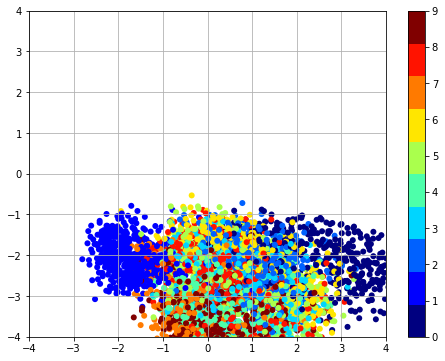

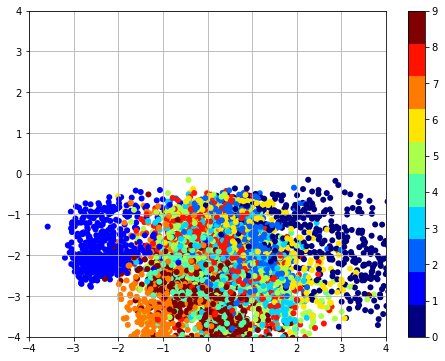

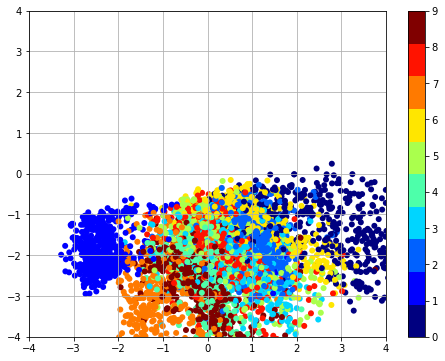

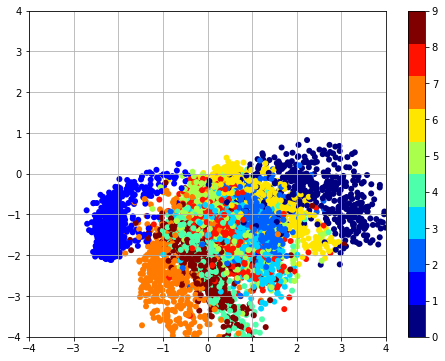

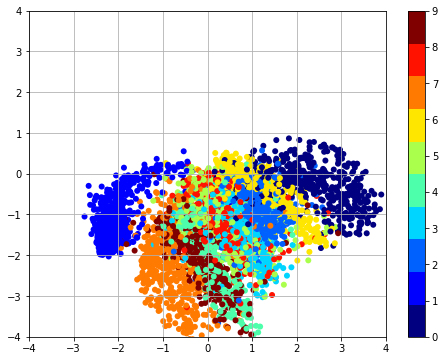

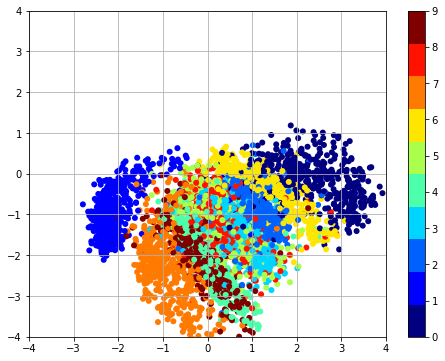

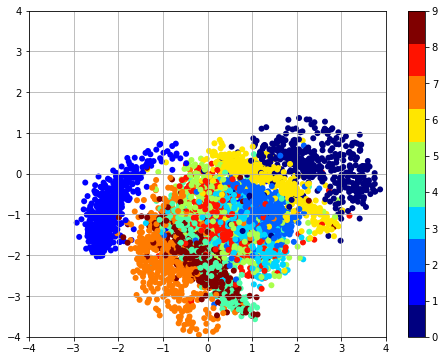

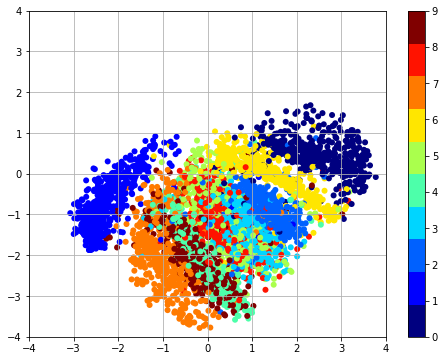

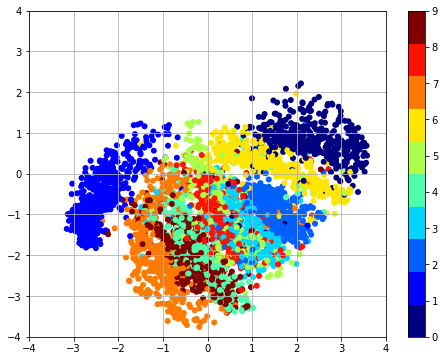

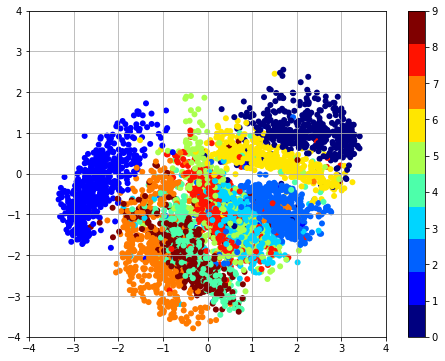

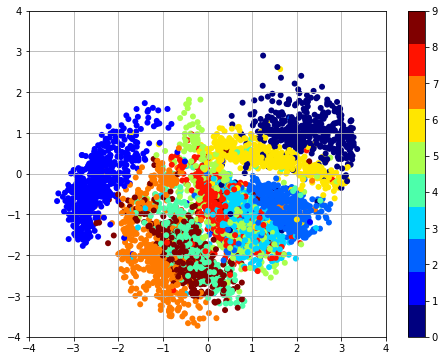

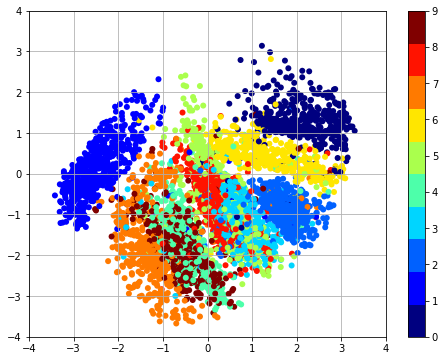

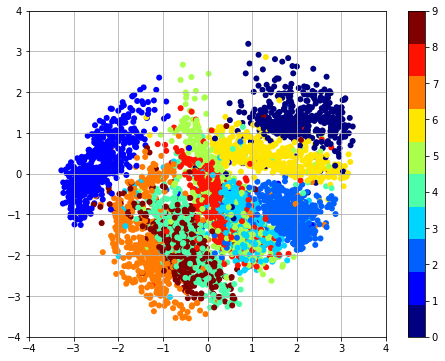

In [7]:
np.random.seed(100)
n_samples=train_size

""" training """

# Plot for reproduce performance
if PRR:
    PRR = plot_utils.Plot_Reproduce_Performance(RESULTS_DIR, PRR_n_img_x, PRR_n_img_y, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST, PRR_resize_factor)

    x_PRR = test_data[0:PRR.n_tot_imgs, :]

    x_PRR_img = x_PRR.reshape(PRR.n_tot_imgs, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST)
    PRR.save_images(x_PRR_img, name='input.jpg')

    if ADD_NOISE:
        x_PRR = x_PRR * np.random.randint(2, size=x_PRR.shape)
        x_PRR += np.random.randint(2, size=x_PRR.shape)

        x_PRR_img = x_PRR.reshape(PRR.n_tot_imgs, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST)
        PRR.save_images(x_PRR_img, name='input_noise.jpg')
# Plot for manifold learning result
if PMLR and dim_z == 2:

    PMLR = plot_utils.Plot_Manifold_Learning_Result(RESULTS_DIR, PMLR_n_img_x, PMLR_n_img_y, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST, PMLR_resize_factor, PMLR_z_range)

    x_PMLR = test_data[0:PMLR_n_samples, :]
    id_PMLR = test_labels[0:PMLR_n_samples, :]

    if ADD_NOISE:
        x_PMLR = x_PMLR * np.random.randint(2, size=x_PMLR.shape)
        x_PMLR += np.random.randint(2, size=x_PMLR.shape)

    decoded = vae.decoder(z_in, dim_img, n_hidden)

total_batch = int(n_samples / batch_size)
min_tot_loss = 1e99
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.05  # 占用GPU90%的显存
sess = tf.Session(config=config)
# with tf.Session() as sess:

sess.run(tf.global_variables_initializer(), feed_dict={keep_prob : 0.9})

for epoch in range(n_epochs):

    # Random shuffling
    np.random.shuffle(train_total_data)
    train_data_ = train_total_data[:, :-mnist_data.NUM_LABELS]
    train_label_= train_total_data[:, -mnist_data.NUM_LABELS:]
    
    # Loop over all batches
    for i in range(total_batch):
        # Compute the offset of the current minibatch in the data.
        offset = (i * batch_size) % (n_samples)
        batch_xs_input = train_data_[offset:(offset + batch_size), :]
        batch_xs_label = train_label_[offset:(offset + batch_size), :]
        batch_xs_target = batch_xs_input

        # add salt & pepper noise
        if ADD_NOISE:
            batch_xs_input = batch_xs_input * np.random.randint(2, size=batch_xs_input.shape)
            batch_xs_input += np.random.randint(2, size=batch_xs_input.shape)

        _, tot_loss, loss_likelihood, loss_divergence,class_loss= sess.run(
            (train_op, loss, neg_marginal_likelihood, KL_divergence,classifation_loss),
            feed_dict={x_hat: batch_xs_input, x: batch_xs_target, x_label:batch_xs_label,keep_prob : 0.9})

    # print cost every epoch
    print("epoch %d: L_tot %03.2f L_likelihood %03.2f L_divergence %03.2f classifation_loss %03.2f " % (epoch, tot_loss, loss_likelihood, loss_divergence,class_loss))

    # if minimum loss is updated or final epoch, plot results
    if min_tot_loss > tot_loss or epoch+1 == n_epochs:
        min_tot_loss = tot_loss
        # Plot for reproduce performance
        if PRR:
            y_PRR = sess.run(y, feed_dict={x_hat: x_PRR, keep_prob : 1})
            y_PRR_img = y_PRR.reshape(PRR.n_tot_imgs, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST)
            PRR.save_images(y_PRR_img, name="/PRR_epoch_%02d" %(epoch) + ".jpg")
        # Plot for manifold learning result
        if PMLR and dim_z == 2:
            y_PMLR = sess.run(decoded, feed_dict={z_in: PMLR.z, keep_prob : 1})
            y_PMLR_img = y_PMLR.reshape(PMLR.n_tot_imgs, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST)
            PMLR.save_images(y_PMLR_img, name="/PMLR_epoch_%02d" % (epoch) + ".jpg")

            # plot distribution of labeled images
            z_PMLR = sess.run(z, feed_dict={x_hat: x_PMLR, keep_prob : 1})
            PMLR.save_scattered_image(z_PMLR,id_PMLR, name="/PMLR_map_epoch_%02d" % (epoch) + ".jpg")

### 测试隐空间分类器

In [11]:
test_batch_size=2
test_batch=int(test_data.shape[0]/test_batch_size)
c=0
for offset in range(test_batch):
    x_batch=test_data[offset*test_batch_size:(offset+1)*test_batch_size]
    label_batch=test_labels[offset*test_batch_size:(offset+1)*test_batch_size]
    label = sess.run(z_class, feed_dict={x_hat: x_batch,keep_prob : 1})
    c+=np.sum(np.argmax(label,axis=1)==np.argmax(label_batch,axis=1))
print(c/test_batch/test_batch_size)

0.9575
